<b>This Notebook contains the following steps:
    1. Graphs for both Big and Small Graph to understand the node connections
    2. Matrix calculation
    3. Ranks with Nodes
    4. Best and worst 5 nodes

In [41]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
f = pd.read_csv('graph-small.txt',header=None, sep='\t')
f.head(2)

0  1
0  100  1
1   13  1

D:\anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


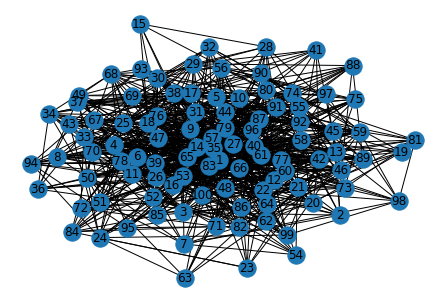

In [44]:
df = pd.DataFrame({ 'from':list(f[0]), 'to':list(f[1])})
# create the graph
G= nx.from_pandas_edgelist(df, 'from', 'to')
 
# Plot 
nx.draw(G, with_labels=True)
plt.show()

# Dense full graph

In [45]:
f1 = pd.read_csv('graph-full.txt',header=None, sep='\t')

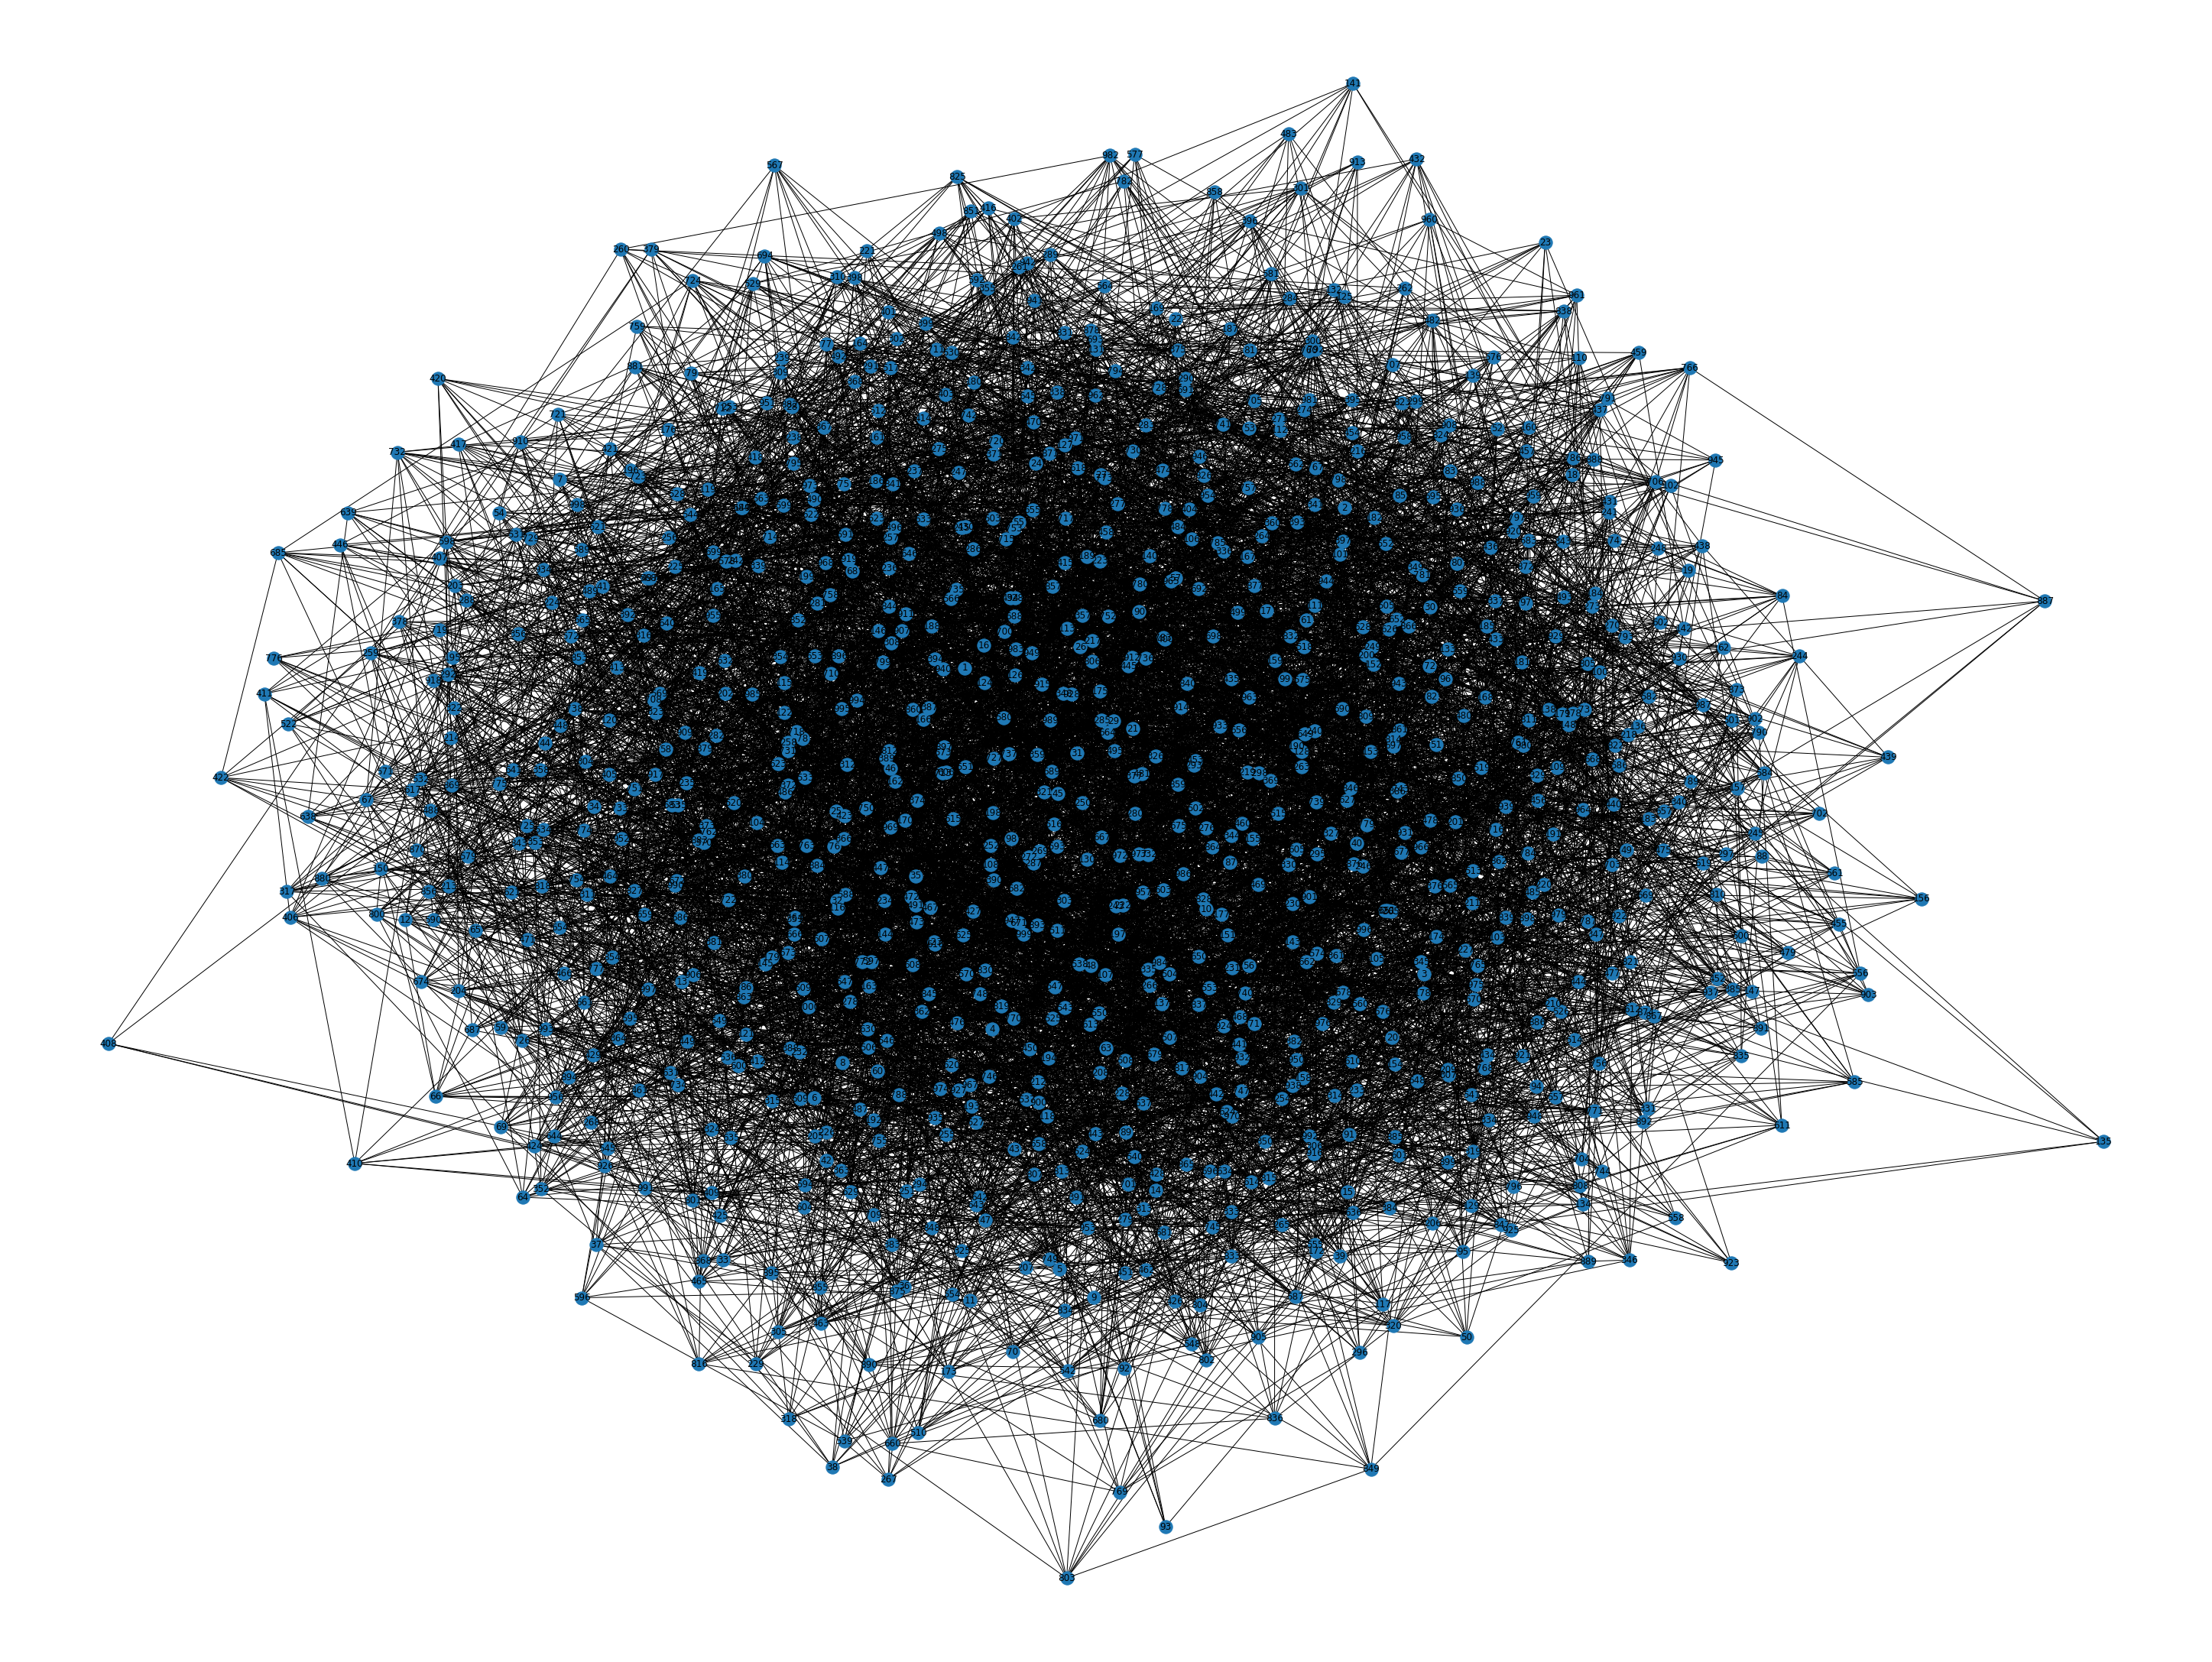

In [46]:
df1 = pd.DataFrame({ 'from':list(f1[0]), 'to':list(f1[1])})
 
# Build your graph
G1= nx.from_pandas_edgelist(df1, 'from', 'to')
 
# Plot it
#nx.draw(G1, with_labels=True,)
plt.figure(3,figsize=(40,30)) 
#nx.draw(G1)
nx.draw(G1, with_labels=True,)
plt.show()
 

# PAGE RANK

In [31]:
from pyspark import SparkContext 
import re
from pyspark.sql import SparkSession
from functools import reduce
from operator import add
import numpy as np

In [25]:
spark = SparkContext()

In [52]:
dataset_path = r'C:\Users\Swayanshu\graph-full.txt'
iterations = 40
beta = 0.8

In [53]:
def matrix_calculation(in_nodes, vertices_count, deg_of_nodes):
    matrix_row = [0] * vertices_count
    for element in in_nodes:
        matrix_row[element-1] = 1.0 / deg_of_nodes[element-1]
    return np.array(matrix_row)

In [54]:
def Page_Rank(dataset_path, iterations, beta):
    out_nodes = spark.textFile(dataset_path).map(lambda x: tuple(map(int, x.split('\t')))).distinct().groupByKey()
    in_nodes = spark.textFile(dataset_path).map(lambda x: tuple(map(int, x.split('\t')))).distinct().map(lambda l:(l[1],l[0])).groupByKey().sortByKey()
    deg_of_nodes = out_nodes.sortByKey().map(lambda x: len(x[1])).collect()
    vertices_count = out_nodes.count()
    matrix_m = in_nodes.map(lambda x: matrix_calculation(x[1],vertices_count,deg_of_nodes))
    r_array = np.array([1.0 /vertices_count] * vertices_count)
    for i in range(iterations):
        r_array_temp = matrix_m.map(lambda l: (((1-beta)/vertices_count)) + (beta*np.dot(l,r_array)))
        r_array = r_array_temp.collect()
        best_5_nodes = sorted(range(len(r_array)), key=lambda k: r_array[k], reverse=True)[:5]
        print()
        print("Iteration " +str(i+1)+":")
        print()
        for i in best_5_nodes:
            print(str(i+1) + ": " + str(r_array[i]))
    return r_array

In [55]:
r_array = Page_Rank(dataset_path, iterations, beta)


Iteration 1:

263: 0.0018759018759018757
502: 0.001866349206349206
126: 0.001843125763125763
285: 0.001819076479076479
146: 0.0018094549894549896

Iteration 2:

263: 0.0020887152258490605
965: 0.0019612553136778245
537: 0.0018784860606765365
243: 0.0018250404103778125
285: 0.0018120241867479964

Iteration 3:

263: 0.0020238066893208664
537: 0.0019302214828365047
965: 0.0019265979884266352
243: 0.0018556711996323288
285: 0.001841159061219935

Iteration 4:

263: 0.0020124609096470636
537: 0.0019423422859068046
965: 0.0019272412154498733
243: 0.001851426809420244
285: 0.0018288144290373816

Iteration 5:

263: 0.002021301319496238
537: 0.0019452806944060199
965: 0.0019258364033716434
243: 0.0018530462087332255
285: 0.001827632665451319

Iteration 6:

263: 0.002020648241069512
537: 0.001943229266241231
965: 0.0019250388507970088
243: 0.0018527946111016682
285: 0.0018273513860454682

Iteration 7:

263: 0.002020369601235597
537: 0.0019433250535116563
965: 0.0019253675166134977
243: 0.0018525

#### Code to print top 5 and bottom 5 nodes

In [51]:
worst_5_nodes  = sorted(range(len(r_array)), key=lambda k: r_array[k])[:5]
best_5_nodes = sorted(range(len(r_array)), key=lambda k: r_array[k], reverse=True)[:5]
print("Best 5 Nodes: ")
for i in best_5_nodes:
    print(str(i+1) + ": " + str(r_array[i]))
print()
print("Worst 5 Nodes: ")
for i in worst_5_nodes:
    print(str(i+1) + ": " + str(r_array[i]))

Best 5 Nodes: 
53: 0.0357312022326716
14: 0.03417090697259137
40: 0.03363008718974388
1: 0.030005979479788617
27: 0.029720144201405382

Worst 5 Nodes: 
85: 0.003409694077402821
59: 0.003669860660127284
81: 0.003695351749360991
37: 0.003808204291611451
89: 0.003922466019802268


# After 35 iteration there is no changes between nodes

After Iteration 40

1. Best 5 Nodes: 
    - 263: 0.002020291181518219
    - 537: 0.0019433415714531497
    - 965: 0.0019254478071662631
    - 243: 0.001852634016241731
    - 285: 0.0018273721700645144

2. Worst 5 Nodes: 
     - 558: 0.0003286018525215297
     - 93: 0.0003513568937516577
     - 62: 0.00035314810510596274
     - 424: 0.00035481538649301454
     - 408: 0.00038779848719291705
